In [ ]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


Para el transformer, definimos la clase para el encoder como se muestra a continuación, y una función que construya el modelo.

In [ ]:
# definición del positional encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # posiciones pares (sin)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # posiciones impares (cos)
    return angle_rads

In [ ]:
# encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads, d_model, dff, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),  # Capa de feedforward expandida
            layers.Dense(d_model)  # Capa que reduce al tamaño original
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask=None):
        attn_output = self.mha(x, x, x, attention_mask=mask)  # Atención a sí mismo
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection + Normalización

        ffn_output = self.ffn(out1)  # Paso por la red FFN
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection + Normalización
        return out2

In [ ]:
def build_transformer_model(input_shape, num_heads=4, d_model=128, dff=512, num_layers=3, target_size=5):
    inputs = layers.Input(shape=input_shape)

    # positional encoding
    pos_encoding = positional_encoding(input_shape[0], d_model)
    x = layers.Dense(d_model)(inputs)
    x += pos_encoding  # Agregar el encoding posicional

    # se crean las etapas del encoder
    for _ in range(num_layers):
        encoder_layer = TransformerEncoder(num_heads, d_model, dff)
        x = encoder_layer(x, training=True)

    # para la salida
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(target_size * input_shape[1])(x)  # salida final con 5 predicciones para cada criptomoneda
    outputs = layers.Reshape((target_size, input_shape[1]))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


Cargamos datos.

In [ ]:
# cargamos los datos de entrenamiento y test que se usaron en el modelo seq2seq para
# que sea entrenado y probado con el mismo set de datos y así tener comparaciones
# bajo las 'mismas condiciones'
X_train = np.load('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/X_train.npy')
X_test = np.load('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/X_test.npy')
y_train = np.load('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/y_train.npy')
y_test = np.load('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/y_test.npy')

Se pide probar con dos normalizaciones. Primero, normalizamos usando el MinMaxScaler para entrenar un modelo bajo esa normalización.

In [ ]:
scaler_train = []
scaler_test = []

X_train_scaled = []
X_test_scaled = []
y_train_scaled = []
y_test_scaled = []

for i in range(len(X_train)):
    scaler_train.append(MinMaxScaler())
    X_train_scaled.append(scaler_train[i].fit_transform(X_train[i]))
    y_train_scaled.append(scaler_train[i].transform(y_train[i]))

X_train_scaled = np.array(X_train_scaled)
y_train_scaled = np.array(y_train_scaled)

for i in range(len(X_test)):
    scaler_test.append(MinMaxScaler())
    X_test_scaled.append(scaler_test[i].fit_transform(X_test[i]))
    y_test_scaled.append(scaler_test[i].transform(y_test[i]))

X_test_scaled = np.array(X_test_scaled)
y_test_scaled = np.array(y_test_scaled)

Definimos el modelo. Por recomendaciones del profesor, es que tiene esos parámetros, pues inicialmente había puesto, por ejemplo, 4 cabezas de atención.

La desventaja de aquellos parámetros fue que el número de parámetros era elevado (arriba de un millón), lo que impedía considerablemente que la pérdida bajara, pues eran demasiados parámetros para la cantidad de datos.

In [ ]:
input_shape = (95, 7)
model1 = build_transformer_model(input_shape, num_heads=1, d_model=32, dff=128)
model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 95, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 95, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_4 (Add)                          │ (None, 95, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_12               │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_13               │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_14               │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 35)                  │           1,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 5, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,523 (154.39 KB)

 Trainable params: 39,523 (154.39 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el primer modelo con los datos normalizados con MinMaxScaler, guardando aquel que tenga menor pérdida en la validación.

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_MaxMin.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
model1.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[checkpoint_callback])

Epoch 1/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1278
Epoch 1: val_loss improved from inf to 0.04223, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_MaxMin.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 52s 95ms/step - loss: 0.1277 - val_loss: 0.0422
Epoch 2/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0418
Epoch 2: val_loss improved from 0.04223 to 0.03420, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_MaxMin.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - loss: 0.0418 - val_loss: 0.0342
Epoch 3/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0344
Epoch 3: val_loss improved from 0.03420 to 0.03141, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_MaxMin.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - loss: 0.0344 - val_loss: 0.0314
Epoch 4/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0332
Epoch 4: val_loss did not improve from 0.03141
434/434 ━━

La siguiente función es para graficar dos series por cada criptomoneda (la elección del par de series es aleatoria) para que en la parte de las comparativas podamos visualizar los resultados.

In [ ]:
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'SOL-USD', 'DOT-USD']

def plot_sequences(true_sequence, predicted_sequence, num_features=7):
    plt.figure(figsize=(15, 10))
    indexes = np.random.randint(0, len(predicted_sequence), size=2)
    for num in range(num_features):
        plt.subplot(3, 3, num + 1)
        for index in indexes:
            plt.plot(true_sequence[index, :, num], label='Real', color='blue', alpha=0.6)
            plt.plot(predicted_sequence[index, :, num], label='Predicción', color='orange', linestyle='--', alpha=0.6)

            # añadimos la recta que representa un valor constante de la cripto, para tenerla en cuenta en las comparativas
            last_value = true_sequence[index, 0, num]
            plt.axhline(y=last_value, color='green', linestyle=':', label='Precio Constante' if index == 0 else "_nolegend_")

        plt.title(f'Secuencias: {cryptos[num]}', fontsize=14)
        plt.xlabel('Tiempo', fontsize=12)
        plt.ylabel('Valor', fontsize=12)
        plt.legend()
        plt.grid()
        plt.tight_layout()  #
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.show()

Obtenemos las predicciones con el modelo entrenado y reescalamos los datos usando la transformación inversa del MinMaxScaler. Estas predicciones serán revisadas en la parte de las comparativas.

In [ ]:
pred_minmax = model1.predict(X_test_scaled)

pred_minmax_rescaled = []
for i in range(len(pred_minmax)):
  pred_minmax_rescaled.append(scaler_test[i].inverse_transform(pred_minmax[i]))

pred_minmax_rescaled = np.array(pred_minmax_rescaled)
np.save('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/pred_minmax_rescaled.npy', pred_minmax_rescaled)

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


Ahora, vamos a entrenar un nuevo modelo que esté preparado para recibir los datos escalados de forma logarítmica. Hay que hacer notar que, esta transformación de los datos "eleva" los valores pequeños, mientras que para valores altos, los "baja", logrando así un escalamiento de los datos en el que los valores pequeños ahora tienen un impacto mayor.

In [ ]:
epsilon = 1e-9  # Pequeño valor para evitar log(0)
X_train_log = []
y_train_log = []
X_test_log = []
y_test_log = []

for i in range(len(X_train)):
    X_train_log.append(np.log(X_train[i] + epsilon))
    y_train_log.append(np.log(y_train[i] + epsilon))

X_train_log = np.array(X_train_log)
y_train_log = np.array(y_train_log)

for i in range(len(X_test)):
    X_test_log.append(np.log(X_test[i] + epsilon))
    y_test_log.append(np.log(y_test[i] + epsilon))

X_test_log = np.array(X_test_log)
y_test_log = np.array(y_test_log)

Creamos un modelo 2 con las mismas características que el 1, salvo que los datos con los que se entrenara son los escalados con el logaritmo.

In [ ]:
input_shape = (95, 7)
model2 = build_transformer_model(input_shape, num_heads=1, d_model=32, dff=128)
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 95, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 95, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_1 (Add)                          │ (None, 95, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_3                │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_4                │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_5                │ (None, 95, 32)              │          12,704 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 35)                  │           1,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 5, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,523 (154.39 KB)

 Trainable params: 39,523 (154.39 KB)

 Non-trainable params: 0 (0.00 B)

Al igual que el caso anterior, se entrena el modelo con los datos correspondientes, guardando el modelo con la menor pérdida en la validación.

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_log.keras',  # Ruta donde se guardará el modelo
    monitor='val_loss',          # Métrica a monitorear
    save_best_only=True,         # Guardar solo el mejor modelo
    mode='min',                  # Guardar el modelo con la menor pérdida
    verbose=1                    # Mostrar mensaje cada vez que se guarda el mejor modelo
)
model2.fit(X_train_log, y_train_log, epochs=30, batch_size=32, validation_data=(X_test_log, y_test_log), callbacks=[checkpoint_callback])

Epoch 1/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 10.0483
Epoch 1: val_loss improved from inf to 0.03647, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_log.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 59s 110ms/step - loss: 10.0342 - val_loss: 0.0365
Epoch 2/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0311
Epoch 2: val_loss improved from 0.03647 to 0.01622, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_log.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.0311 - val_loss: 0.0162
Epoch 3/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0138
Epoch 3: val_loss improved from 0.01622 to 0.00974, saving model to /content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/bm_log.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 4/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0076
Epoch 4: val_loss improved from 0.00974 to 0.00607, saving mo

Obtenemos predicciones.

In [ ]:
pred_log = model2.predict(X_test_log)

pred_log_rescaled = []
for i in range(len(pred_log)):
  pred_log_rescaled.append(np.exp(pred_log[i]) - epsilon)

pred_log_rescaled = np.array(pred_log_rescaled)
np.save('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/pred_log_rescaled.npy', pred_log_rescaled)

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


# Comparaciones y conclusiones

Usando la función antes mencionada, graficamos dos predicciones tomadas aleatoriamente por cada criptomoneda. Esto nos permite ver el comportamiento de las predicciones para dos casos aleatoriamente distintos.

Estas primeras gráficas son las predicciones obtenidas mediante el modelo Seq2seq de la tarea anterior. De este modelo solo exportamos las predicciones y las cargamos aqui para su visualización.

In [ ]:
pred_s2s = np.load('/content/drive/My Drive/Aprendizaje Automático/Curso 2/Datos T3/predictions_s2s.npy')

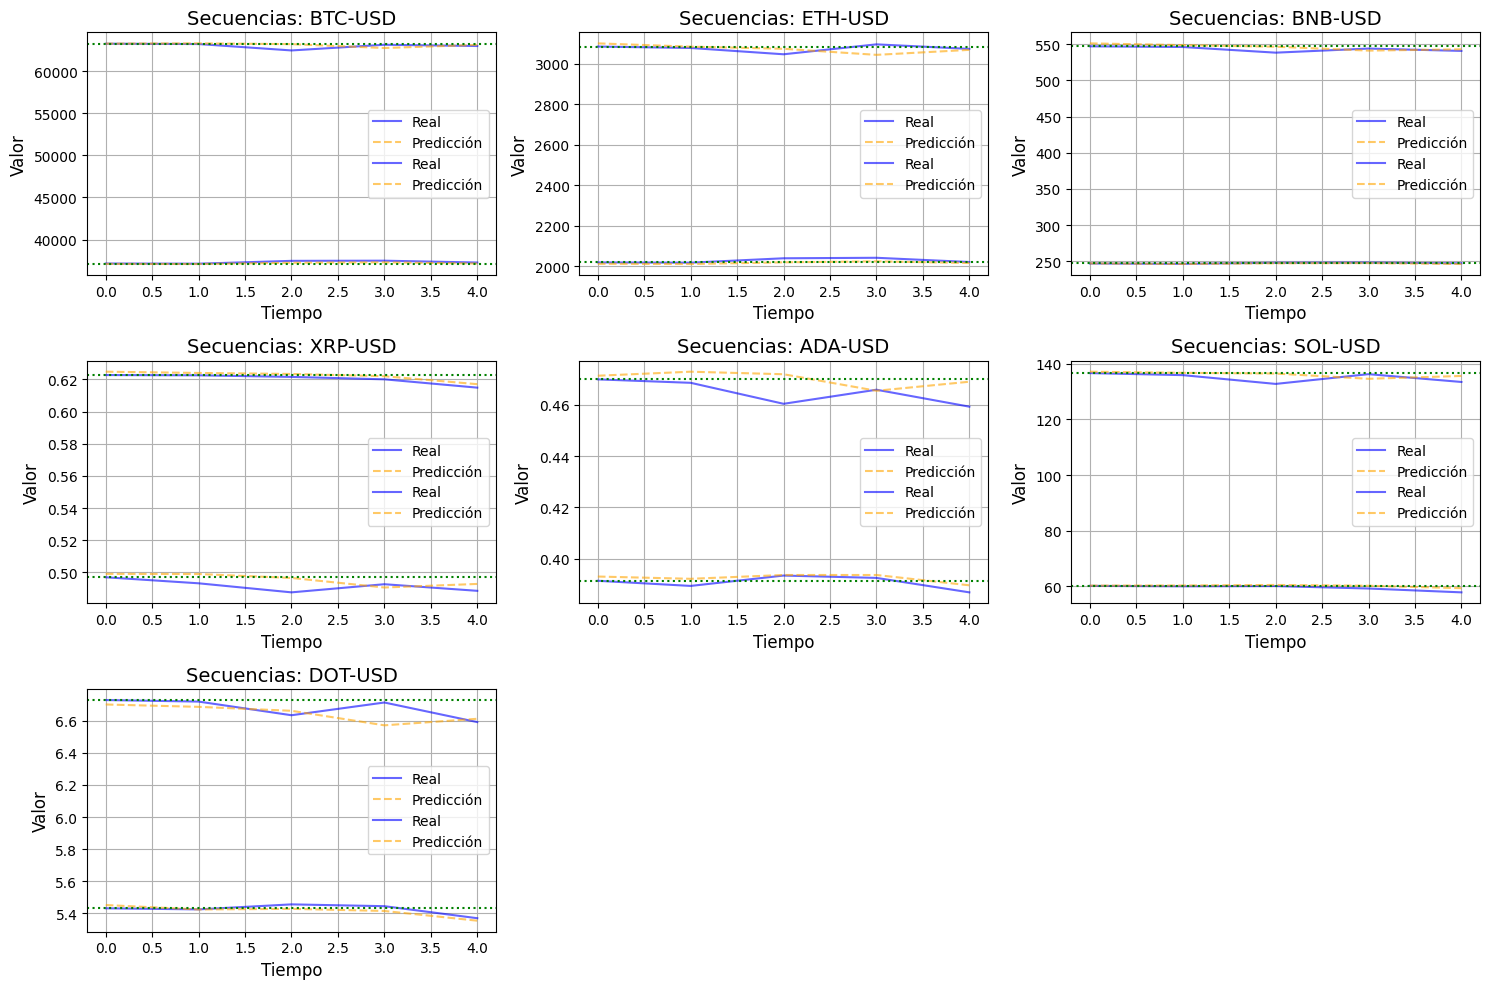

In [ ]:
plot_sequences(y_test, pred_s2s)

Estas soguientes gráficas son las correspondientes al modelo 1, en el podemos ver el precio predicho por el modelo, al igual que la gráfica suponiendo que el precio se mantuvo constante. Desde la pérdida durante el entrenamiento se podía ver que se esperaban resultados consistentes a lo que se esperaba, después de considerar los resultados con el modelo S2S.

Se puede observar un buen ajuste general, pero donde si se notan cambios considerables es en las criptomonedas que tienen menor valor. En el modelo s2s, el ajuste general del comportamiento de los precios era bueno, si bien, lógicamente había variación en los precios, este era más reducido que el que se puede ver en estas criptomonedas, aunque ya es bueno que en este modelo 1, el comportamiento del precio para ser bien representado.

Sobre la comparación con un precio estable y fijo, desde luego esta aproximación al precio puede ser más acertada que el modelo, pero la diferencia es que no captura el comportamiento que el precio real tiene, mientras que el modelo 1 hace un mejor trabajo en ese sentido.

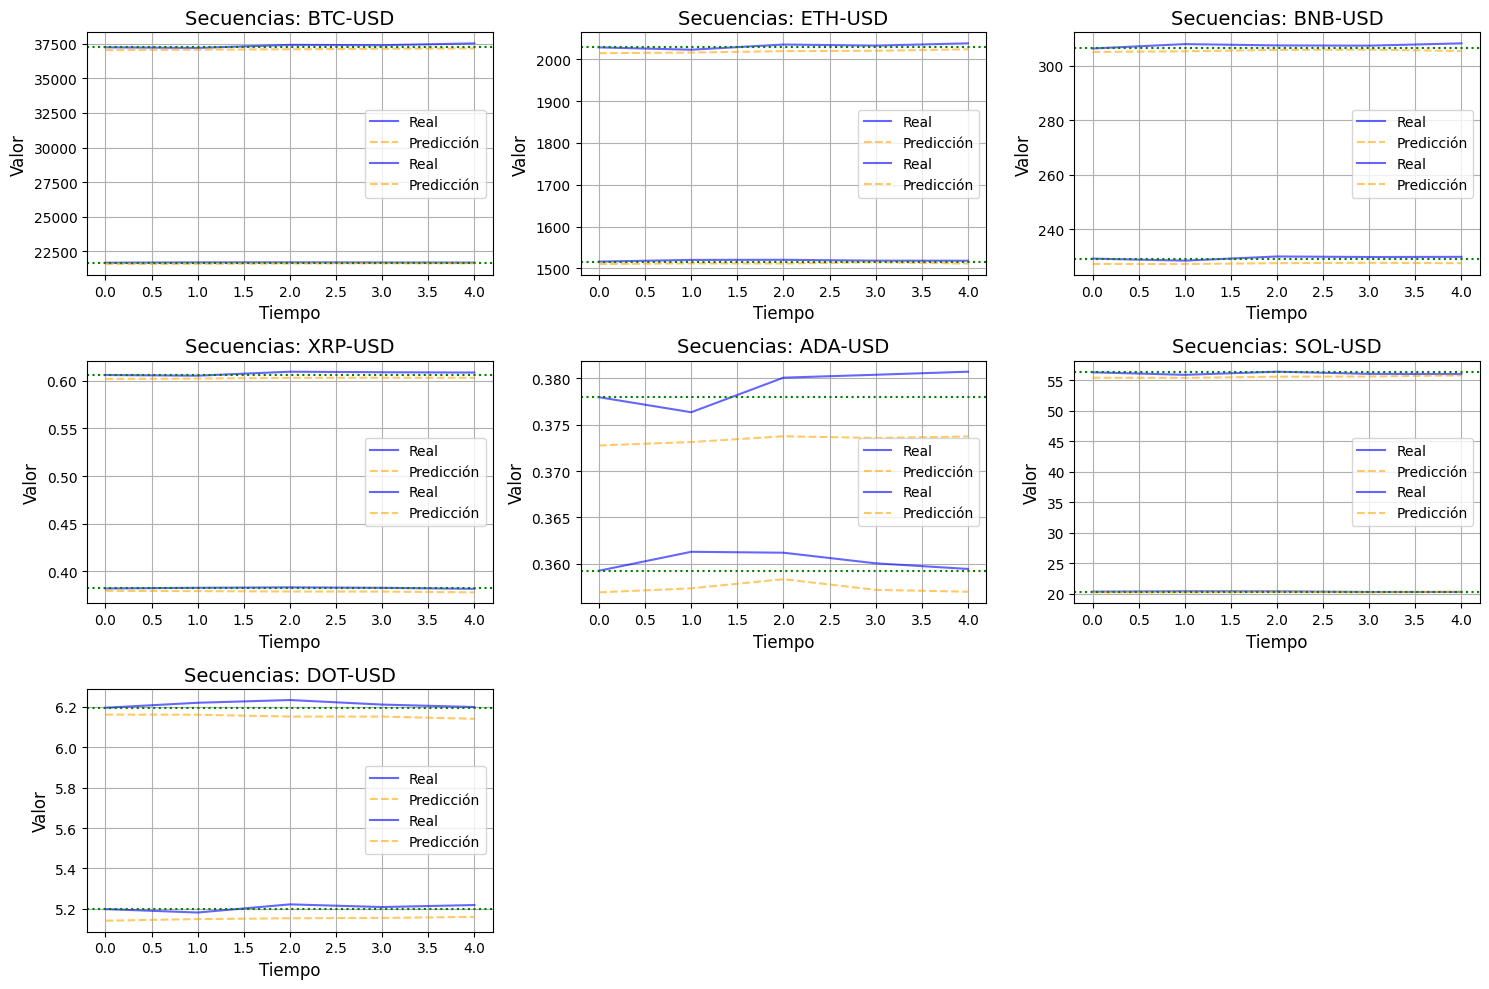

In [ ]:
plot_sequences(y_test, pred_minmax_rescaled)

Estas siguientes gráficas son las predicciones del modelo 2. Inmediatamente se puede ver una diferencia considerable, pues los precios de las criptos parecen ser un mayor problema, pues aunque hay casos en el que la predicción es bastante acertada, si hay una variación más destacable que con el modelo anterior.

Además, el comportamiento de los precios también parece ser algo importante a destacar, pues en la mayoría de los casos, el comportamiento es considerablemente distinto al real, siendo esta la mayor diferencia en comparación con el modelo 1.

En cuanto a la comparación con el precio fijo, sobra decir que considerar una aproximación de ese tipo es más cercana que la comparación con este modelo 2.

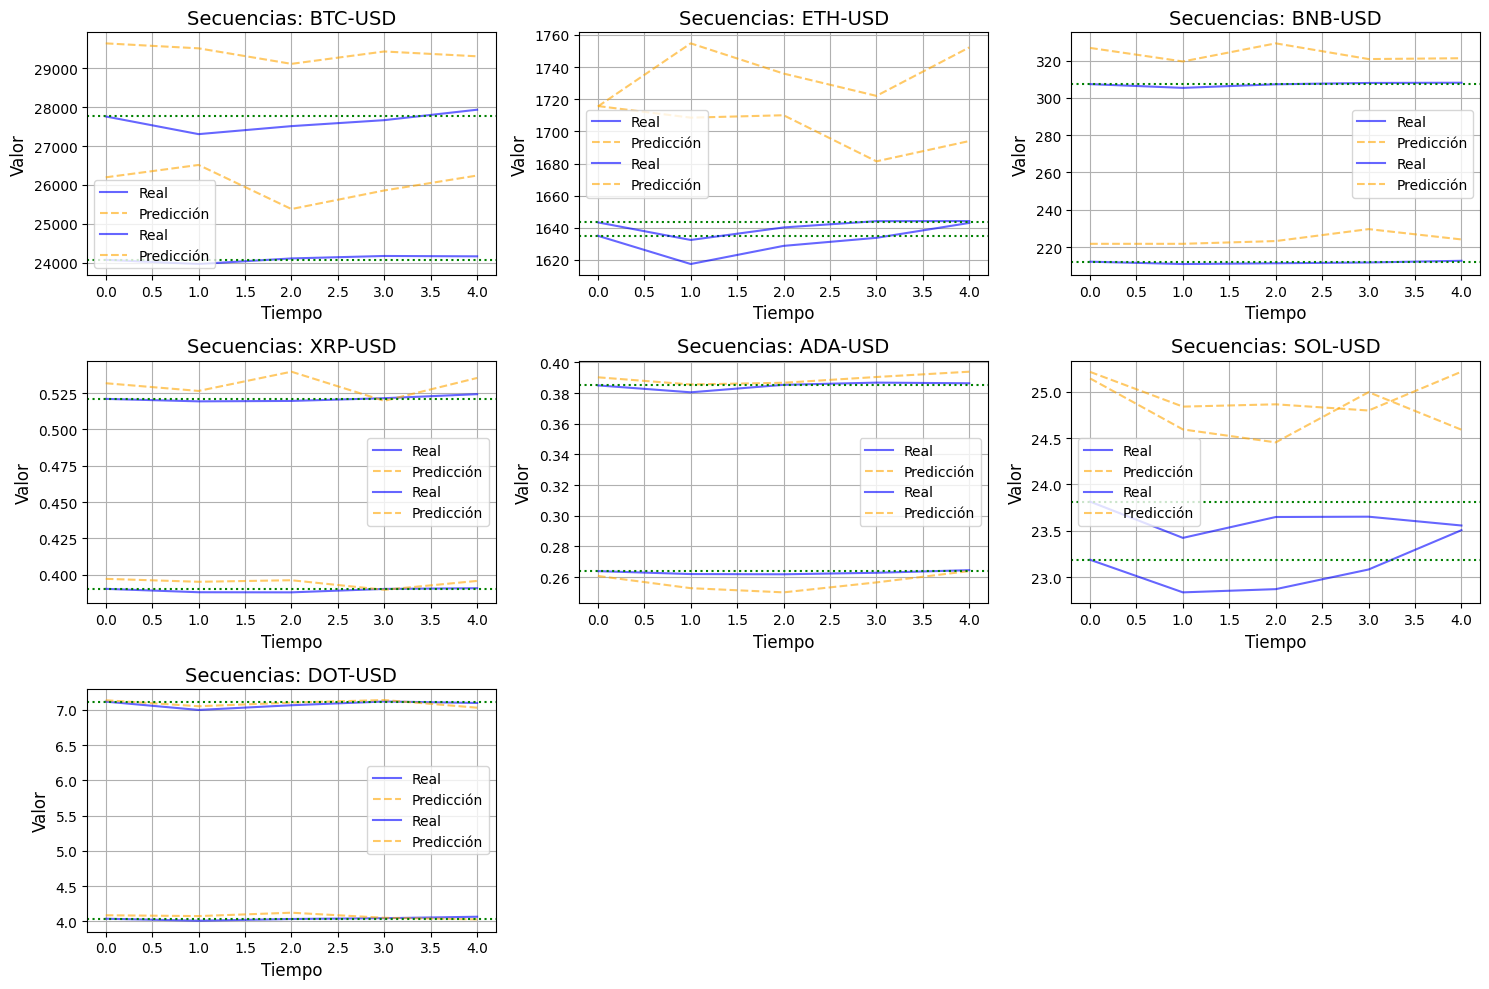

In [ ]:
plot_sequences(y_test, pred_log_rescaled)

## Comentarios finales.
La realidad es que ambos modelos tienen lo suyo. Sin embargo, en la vida práctica sería más útil un modelo como el 1, pues, muchas veces no se requiere saber tanto el precio de la criptomoneda como si es necesario saber su comportamiento. Para compra/venta de los mismos, desde luego es importante saber el precio, pero es un factor determinante saber el comportamiento futuro, pues de eso depende la compra y venta, de si los precios suben o bajan. Esa información esta mucho mejor representada en el modelo 1.

Sobre una decisión entre el modelo s2s y el modelo 1, la realidad es que a esta escala, tienen un desempeño muy similar, sin embargo, hay que recordar que el modelo 1 es un transformer, el cual tiene otras caracteríticas que pueden afinarse e incluso mejorarse para lograr una mejor predicción tanto en el precio como en el comportamiento de cada cripto. Siempre y cuando haya suficientes datos para entrenar un modelo más robusto, el transformer podría mejorar su desempeño aún más.